<a href="https://colab.research.google.com/github/trappertwo/rPPG_experiments/blob/main/swinir_with_cropped_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [23]:
!python --version
# Imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

!pip install -q mediapy
import mediapy as media


Python 3.12.11


In [24]:
# Download SwinIR pretrained models
!rm -r SwinIR
# Clone SwinIR
!git clone https://github.com/trappertwo/SwinIR.git
!pip install timm

# Download the pre-trained models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg20.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg30.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg40.pth -P experiments/pretrained_models

rm: cannot remove 'SwinIR': No such file or directory
Cloning into 'SwinIR'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 336 (delta 8), reused 2 (delta 2), pack-reused 323 (from 2)
Receiving objects: 100% (336/336), 29.84 MiB | 38.82 MiB/s, done.
Resolving deltas: 100% (121/121), done.
--2025-08-25 04:18:24--  https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/396770997/2c43e270-4a3e-4893-8920-1dc0550fec2f?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-25T05%3A09%3A55Z&rscd=attachment%3B+filename%3D006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth&rsct=application%2Foctet-stream&s

In [25]:
# Download the Swin2SR pretrained model
!wget https://github.com/mv-lab/swin2sr/releases/tag/v0.0.1/Swin2SR_Jpeg_dynamic.pth -P experiments/pretrained_models

--2025-08-25 04:18:36--  https://github.com/mv-lab/swin2sr/releases/tag/v0.0.1/Swin2SR_Jpeg_dynamic.pth
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘experiments/pretrained_models/Swin2SR_Jpeg_dynamic.pth’

Swin2SR_Jpeg_dynami     [ <=>                ] 180.72K  --.-KB/s    in 0.03s   

2025-08-25 04:18:37 (5.39 MB/s) - ‘experiments/pretrained_models/Swin2SR_Jpeg_dynamic.pth’ saved [185057]



In [26]:
## Preprocessing - face detection
import cv2
import datetime
import math
from cv2 import dnn_superres


def read_video(video_file):
    """Reads a video file, returns frames(T, H, W, 3) """
    VidObj = cv2.VideoCapture(video_file)
    VidObj.set(cv2.CAP_PROP_POS_MSEC, 0)
    success, frame = VidObj.read()
    frames = list()
    while success:
      frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2RGB)
      frame = np.asarray(frame)
      frames.append(frame)
      success, frame = VidObj.read()
    return np.asarray(frames)

def face_detection(frame, backend, use_larger_box=False, larger_box_coef=1.0):
        """Face detection on a single frame.

        Args:
            frame(np.array): a single frame.
            backend(str): backend to utilize for face detection.
            use_larger_box(bool): whether to use a larger bounding box on face detection.
            larger_box_coef(float): Coef. of larger box.
        Returns:
            face_box_coor(List[int]): coordinates of face bouding box.
        """
        if backend == "HC":
            # Use OpenCV's Haar Cascade algorithm implementation for face detection
            # This should only utilize the CPU
            detector = cv2.CascadeClassifier(
            '/content/drive/MyDrive/DATASETS/haarcascade_frontalface_default.xml')

            # Computed face_zone(s) are in the form [x_coord, y_coord, width, height]
            # (x,y) corresponds to the top-left corner of the zone to define using
            # the computed width and height.
            face_zone = detector.detectMultiScale(frame)

            if len(face_zone) < 1:
                print("ERROR: No Face Detected")
                face_box_coor = [0, 0, frame.shape[0], frame.shape[1]]
            elif len(face_zone) >= 2:
                # Find the index of the largest face zone
                # The face zones are boxes, so the width and height are the same
                max_width_index = np.argmax(face_zone[:, 2])  # Index of maximum width
                face_box_coor = face_zone[max_width_index]
                print("Warning: More than one faces are detected. Only cropping the biggest one.")
            else:
                face_box_coor = face_zone[0]
        else:
            raise ValueError("Unsupported face detection backend!")

        if use_larger_box:
            face_box_coor[0] = max(0, face_box_coor[0] - (larger_box_coef - 1.0) / 2 * face_box_coor[2])
            face_box_coor[1] = max(0, face_box_coor[1] - (larger_box_coef - 1.0) / 2 * face_box_coor[3])
            face_box_coor[2] = larger_box_coef * face_box_coor[2]
            face_box_coor[3] = larger_box_coef * face_box_coor[3]
        return face_box_coor

In [27]:
import numpy as np
import os
import torch
import sys

# Add the SwinIR directory to the system path
sys.path.append('SwinIR')

from models.network_swinir import SwinIR as net

def load_model(model_path):
  """Loads the pretrained SwinIR model
  """
  # set up model
  if os.path.exists(model_path):
    print(f'loading model from {model_path}')
  else:
    raise ValueError(f'model {model_path} does not exist.')
  model = net(upscale=1, in_chans=3, img_size=126, window_size=7,
        img_range=255., depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
       mlp_ratio=2, upsampler='', resi_connection='1conv')
  param_key_g = 'params'

  pretrained_model = torch.load(model_path)
  model.load_state_dict(pretrained_model[param_key_g] if param_key_g in pretrained_model.keys() else pretrained_model, strict=True)

  return model

def model_inference(img_lq, model, window_size, scale, tile=None, tile_overlap=0):
    if tile is None:
        # test the image as a whole
        output = model(img_lq)
    else:
        # test the image tile by tile
        b, c, h, w = img_lq.size()
        tile = min(tile, h, w)
        assert tile % window_size == 0, "tile size should be a multiple of window_size"
        sf = scale

        stride = tile - tile_overlap
        h_idx_list = list(range(0, h-tile, stride)) + [h-tile]
        w_idx_list = list(range(0, w-tile, stride)) + [w-tile]
        E = torch.zeros(b, c, h*sf, w*sf).type_as(img_lq)
        W = torch.zeros_like(E)

        for h_idx in h_idx_list:
            for w_idx in w_idx_list:
                in_patch = img_lq[..., h_idx:h_idx+tile, w_idx:w_idx+tile]
                out_patch = model(in_patch)
                out_patch_mask = torch.ones_like(out_patch)

                E[..., h_idx*sf:(h_idx+tile)*sf, w_idx*sf:(w_idx+tile)*sf].add_(out_patch)
                W[..., h_idx*sf:(h_idx+tile)*sf, w_idx*sf:(w_idx+tile)*sf].add_(out_patch_mask)
        output = E.div_(W)

    return output

def img_restore_swinir(img_lq, model, window_size=7, scale=10):
  """Restore low quality image by remove compresssion artifacts using SwinIR pretrained model.

    Args:
      img_lq: the low quality image
      model: the pretrained SwinIR model
  """
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  img_lq = img_lq.astype(np.float32)/ 255
  img_lq = np.transpose(img_lq if img_lq.shape[2] == 1 else img_lq[:, :, [2, 1, 0]], (2, 0, 1))  # HCW-BGR to CHW-RGB
  img_lq = torch.from_numpy(img_lq).float().unsqueeze(0).to(device)  # CHW-RGB to NCHW-RGB

  # inference
  with torch.no_grad():
    # pad input image to be a multiple of window_size
    _, _, h_old, w_old = img_lq.size()
    h_pad = (h_old // window_size + 1) * window_size - h_old
    w_pad = (w_old // window_size + 1) * window_size - w_old
    img_lq = torch.cat([img_lq, torch.flip(img_lq, [2])], 2)[:, :, :h_old + h_pad, :]
    img_lq = torch.cat([img_lq, torch.flip(img_lq, [3])], 3)[:, :, :, :w_old + w_pad]
    output = model_inference(img_lq, model, window_size, scale)
    output = output[..., :h_old * scale, :w_old * scale]

    # save image
    output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
    if output.ndim == 3:
      output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))  # CHW-RGB to HCW-BGR
      output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8
      #cv2.imwrite(f'{save_dir}/{imgname}_SwinIR.png', output)

    return output

# Face cropping
def crop_face_resize(frames, use_face_detection,  use_larger_box, larger_box_coef, use_dynamic_detection,
                         detection_freq, use_median_box, width, height,
                     restore=False, model=None):
  """Crop face and resize frames.

     Args:
       frames(np.array): Video frames.
       use_face_detection(bool):  Whether crop the face.
       use_dynamic_detection(bool): If False, all the frames use the first frame's bouding box to crop the faces
                                         and resizing.
                                         If True, it performs face detection every "detection_freq" frames.
       detection_freq(int): The frequency of dynamic face detection e.g., every detection_freq frames.
       width(int): Target width for resizing.
       height(int): Target height for resizing.
       use_larger_box(bool): Whether enlarge the detected bouding box from face detection.
       larger_box_coef(float): the coefficient of the larger region(height and weight)
                             the middle point of the detected region will stay still during the process of enlarging.
       restore(bool): whether to run compression artifact removal (CAR) to restore compressed video frames.
       model(torch.nn.Module): SwinIR model.
     Returns:
       resized_frames(list[np.array(float)]): Resized and cropped frames
  """
  # Face Cropping
  if use_dynamic_detection:
    num_dynamic_det = math.ceil(frames.shape[0] / detection_freq)
  else:
    num_dynamic_det = 1
  face_region_all = []
  # Perform face detection by num_dynamic_det" times.
  for idx in range(num_dynamic_det):
    if use_face_detection:
       face_region_all.append(face_detection(frames[detection_freq * idx], "HC", use_larger_box, larger_box_coef))
    else:
       face_region_all.append([0, 0, frames.shape[1], frames.shape[2]])
  if use_median_box:
     # Generate a median bounding box based on all detected face regions
     face_region_median = np.median(np.asarray(face_region_all, dtype='int'), axis=0).astype('int')
  print(np.asarray(face_region_all, dtype='int'))

  # Frame Resizing
  #resized_frames = np.zeros((frames.shape[0], height, width, 3))
  resized_frames = []
  for i in range(0, frames.shape[0]):
    frame = frames[i]
    if use_dynamic_detection:  # use the (i // detection_freq)-th facial region.
      reference_index = i // detection_freq
    else:  # use the first region obtrained from the first frame.
      reference_index = 0
    if use_face_detection:
      if use_median_box:
         face_region = face_region_median
      else:
         face_region = np.asarray(face_region_all, dtype='int')[reference_index]
      frame = frame[max(face_region[1], 0):min(face_region[1] + face_region[3], frame.shape[0]),
         max(face_region[0], 0):min(face_region[0] + face_region[2], frame.shape[1])]

    # Resize the frame
    resized_frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)

    if restore:
      print("Restoring " + str(i))
      media.show_image(resized_frame)
      resized_frame = img_restore_swinir(resized_frame, model)
      print("After restoration... ")
      media.show_image(resized_frame)

    resized_frames.append(resized_frame)

  return np.array(resized_frames)

def frames_to_video(frames, output_path, fps=30):
    """Converts a sequence of frames to an MPEG4 video.

    Args:
        frames: A list of frames (numpy arrays) to be converted to a video.
        output_path: Name of the output video file (e.g., 'output.mp4').
        fps: Frames per second for the output video.
    """

    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MPEG-4
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      video_writer.write(frame_rgb)

    video_writer.release()

# **Inference**

In [28]:
### UBFC-rPPG dataset in drive folder
### (TODO) Figure out how to import data set directly into colab
from google.colab import drive
import os

SUBJECT = 'subject9' # @param {type : "string"}

drive.mount('/content/drive')
#filepath = '/content/drive/MyDrive/research_project/'
DIR_PATH = '/content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_uncompressed_test' # @param {type: "string"}
filepath = os.path.join(DIR_PATH, SUBJECT)
filepath = os.path.join(filepath, 'vid.mp4')

!ls -l $filepath

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-rw------- 1 root root 274835042 Mar 11 03:58 /content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_uncompressed_test/subject9/vid.mp4


In [29]:
video = media.read_video(filepath)
videos = {'Original': video[:10]}
media.show_videos(videos, fps=30)

In [30]:
# Compress the video with default settings (H.264 codec)
BIT_RATE = "500_000" # @param {type : "string"}
COMPRESSION_BIT_RATES = {BIT_RATE}

compressed_data = {}
i = 0
for bps in COMPRESSION_BIT_RATES:
    compressed_data[bps] = media.compress_video(video, bps=bps, fps=30)
    print(len(compressed_data[bps]))
# Save the compressed video to a file
with open('/tmp/subject1_{BIT_RATE}.mp4', 'wb') as f:
    f.write(compressed_data[BIT_RATE])
# Show original and compressed video side-by-side
compressed_video = media.read_video('/tmp/subject1_{BIT_RATE}.mp4')
videos = {'Original': video[:10],  'Compressed_{BIT_RATE}': compressed_video[:10]}
media.show_videos(videos, fps=30)

8429327


2016



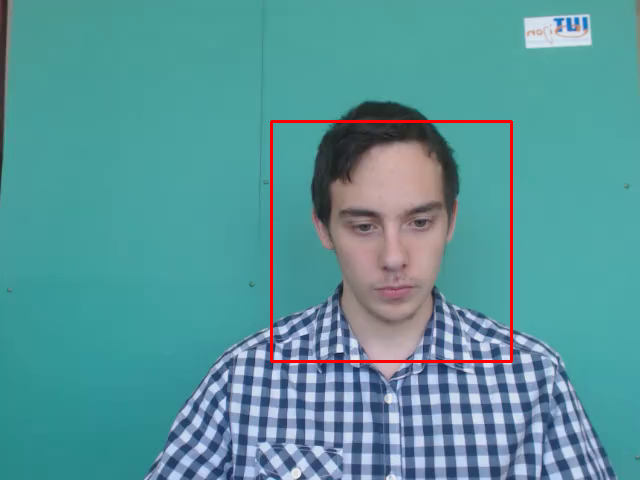

In [31]:
# Check face detection on one frame
print(len(compressed_video))
face_box_coor = face_detection(compressed_video[1], backend='HC', use_larger_box=True, larger_box_coef=1.5)
new_frame = cv2.rectangle(compressed_video[0], (face_box_coor[0], face_box_coor[1]), (face_box_coor[0] + face_box_coor[2], face_box_coor[1] + face_box_coor[3]), (255, 0, 0), 2)
media.show_image(new_frame)

In [32]:
# Load SwinIR model
MODEL_PATH_1 = 'experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg40.pth'
swinir_model1 = load_model(MODEL_PATH)
MODEL_PATH_2 = 'experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg40.pth'
swinir_model2 = load_model(MODEL_PATH)
MODEL_PATH_3 = 'experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg40.pth'
swinir_model3 = load_model(MODEL_PATH)
MODEL_PATH_4 = 'experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg40.pth'
swinir_model4 = load_model(MODEL_PATH)
print(swinir_model4)

loading model from experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg40.pth
loading model from experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg40.pth
loading model from experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg40.pth
loading model from experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg40.pth
SwinIR(
  (conv_first): Conv2d(3, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=180, input_resolution=(126, 126), depth=6
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=180, input_resolution=(126, 126), num_heads=6, window_size=7, shift_size=0, mlp_ratio=2
            (norm1): LayerNorm((180,), eps=1e-05, element

[[271 121 240 240]]
[[271 121 240 240]]
Restoring 0



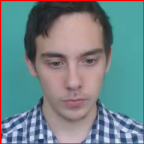

After restoration... 



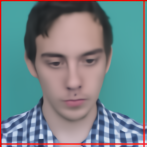

Restoring 1



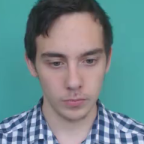

After restoration... 



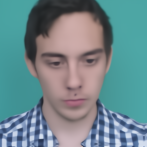

Restoring 2



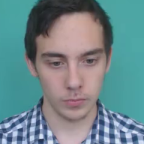

After restoration... 



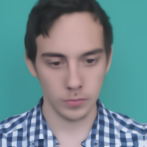

Restoring 3



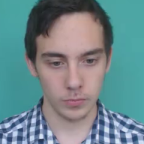

After restoration... 



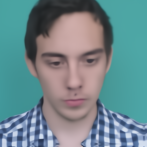

Restoring 4



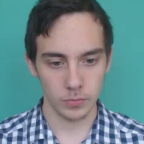

After restoration... 



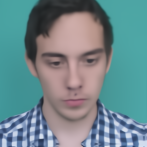

Restoring 5



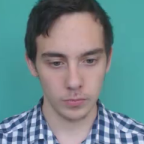

After restoration... 



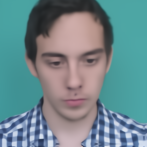

Restoring 6



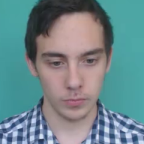

After restoration... 



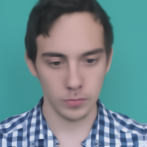

Restoring 7



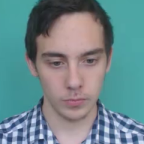

After restoration... 



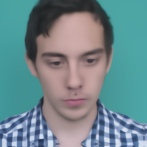

Restoring 8



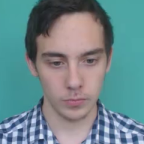

After restoration... 



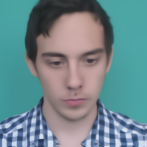

Restoring 9



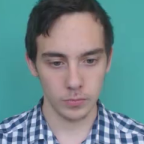

After restoration... 



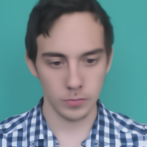

[[271 121 240 240]]
Restoring 0



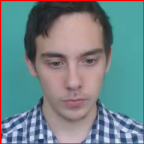

After restoration... 



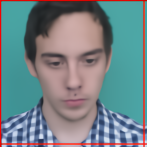

Restoring 1



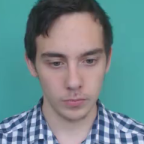

After restoration... 



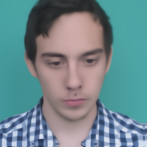

Restoring 2



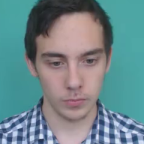

After restoration... 



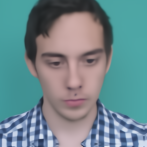

Restoring 3



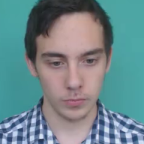

After restoration... 



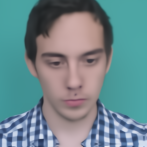

Restoring 4



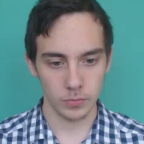

After restoration... 



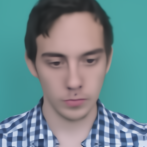

Restoring 5



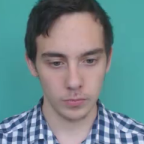

After restoration... 



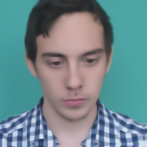

Restoring 6



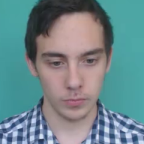

After restoration... 



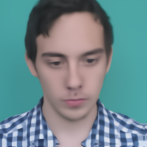

Restoring 7



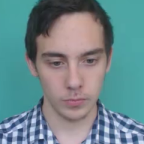

After restoration... 



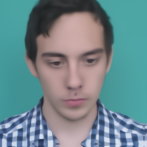

Restoring 8



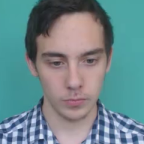

After restoration... 



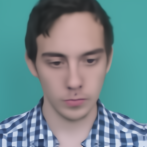

Restoring 9



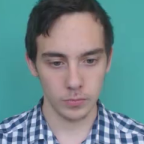

After restoration... 



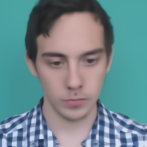

[[271 121 240 240]]
Restoring 0



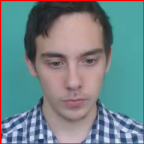

After restoration... 



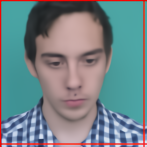

Restoring 1



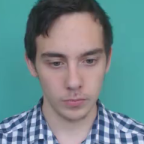

In [ ]:
import os

PREPROCESSED_PATH = '/tmp/' # @param{type: "string"}
path = os.path.join(PREPROCESSED_PATH, SUBJECT)
if not os.path.isdir(path):
  os.mkdir(path)
IMAGE_SIZE = 144 # @param {type: "integer"}

# Generate preprocessed data by just cropping face, resizing the compressed video
preprocessed_data1 = crop_face_resize(compressed_video[:10],
                                     use_face_detection=True,
                                     use_larger_box=True,
                                     larger_box_coef=1.5,
                                     use_dynamic_detection=False,
                                     detection_freq=32,
                                     use_median_box=False,
                                     width=IMAGE_SIZE,
                                     height=IMAGE_SIZE)

# Generate preprocessed data by cropping face, resizing and then restoring the
# frame using SwinIR models
preprocessed_data2 = crop_face_resize(compressed_video[:10],
                                     use_face_detection=True,
                                     use_larger_box=True,
                                     larger_box_coef=1.5,
                                     use_dynamic_detection=False,
                                     detection_freq=32,
                                     use_median_box=False,
                                     width=IMAGE_SIZE,
                                     height=IMAGE_SIZE,
                                     restore=True,
                                     model=swinir_model1)

preprocessed_data3 = crop_face_resize(compressed_video[:10],
                                     use_face_detection=True,
                                     use_larger_box=True,
                                     larger_box_coef=1.5,
                                     use_dynamic_detection=False,
                                     detection_freq=32,
                                     use_median_box=False,
                                     width=IMAGE_SIZE,
                                     height=IMAGE_SIZE,
                                     restore=True,
                                     model=swinir_model2)

preprocessed_data4 = crop_face_resize(compressed_video[:10],
                                     use_face_detection=True,
                                     use_larger_box=True,
                                     larger_box_coef=1.5,
                                     use_dynamic_detection=False,
                                     detection_freq=32,
                                     use_median_box=False,
                                     width=IMAGE_SIZE,
                                     height=IMAGE_SIZE,
                                     restore=True,
                                     model=swinir_model3)

preprocessed_data5 = crop_face_resize(compressed_video[:10],
                                     use_face_detection=True,
                                     use_larger_box=True,
                                     larger_box_coef=1.5,
                                     use_dynamic_detection=False,
                                     detection_freq=32,
                                     use_median_box=False,
                                     width=IMAGE_SIZE,
                                     height=IMAGE_SIZE,
                                     restore=True,
                                     model=swinir_model4)

In [ ]:
SAVE_DIR = '/content/drive/MyDrive/tmp' # @param {type: "string"}
path = os.path.join(SAVE_DIR, SUBJECT)
if not os.path.isdir(path):
  os.mkdir(path)
filepath = os.path.join(SAVE_DIR, SUBJECT, 'vid1.mp4')
print("Writing " + filepath)
frames_to_video(preprocessed_data1, filepath)

filepath = os.path.join(SAVE_DIR, SUBJECT, 'vid2.mp4')
print("Writing " + filepath)
frames_to_video(preprocessed_data2, filepath)
!ls -l {SAVE_DIR}/{SUBJECT}

filepath = os.path.join(SAVE_DIR, SUBJECT, 'vid3.mp4')
print("Writing " + filepath)
frames_to_video(preprocessed_data3, filepath)
!ls -l {SAVE_DIR}/{SUBJECT}

filepath = os.path.join(SAVE_DIR, SUBJECT, 'vid4.mp4')
print("Writing " + filepath)
frames_to_video(preprocessed_data4, filepath)
!ls -l {SAVE_DIR}/{SUBJECT}

filepath = os.path.join(SAVE_DIR, SUBJECT, 'vid5.mp4')
print("Writing " + filepath)
frames_to_video(preprocessed_data5, filepath)
!ls -l {SAVE_DIR}/{SUBJECT}

In [ ]:
cropped_video1 = media.read_video(os.path.join(SAVE_DIR, SUBJECT, 'vid1.mp4'))
cropped_video2 = media.read_video(os.path.join(SAVE_DIR, SUBJECT, 'vid2.mp4'))
cropped_video3 = media.read_video(os.path.join(SAVE_DIR, SUBJECT, 'vid3.mp4'))
cropped_video4 = media.read_video(os.path.join(SAVE_DIR, SUBJECT, 'vid4.mp4'))
cropped_video5 = media.read_video(os.path.join(SAVE_DIR, SUBJECT, 'vid5.mp4'))


videos = {'Without Restoration': cropped_video1, 'With restoration jpeg:10': cropped_video2,
          'With restoration jpeg:20': cropped_video3,
          'With restoration jpeg:30': crropped_video4,
          'With restoration jpeg:40': cropped_video5}
media.show_videos(videos, fps=30)

### Compare SwinIR with Swin2SR

In [ ]:
import torch
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
import cv2
import mediapy as media


from transformers import AutoImageProcessor, Swin2SRForImageSuperResolution

processor = AutoImageProcessor.from_pretrained("caidas/swin2SR-classical-sr-x2-64")
model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x2-64")

#image = Image.open(requests.get(url, stream=True).raw)
image = cropped_video1[0]
# prepare image for the model
inputs = processor(image, return_tensors="pt")

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

output = outputs.reconstruction.data.squeeze().float().cpu().clamp_(0, 1).numpy()
output = np.moveaxis(output, source=0, destination=-1)
output = (output * 255.0).round().astype(np.uint8)
#resized_frame = cv2.resize(output, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
images = {'Original': cropped_video1[0], 'SwinIR': cropped_video2[0], 'Swin2SR': output}
media.show_images(images)

In [ ]:
!git clone https://github.com/mv-lab/swin2sr.git

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

os.chdir("./swin2sr")

In [ ]:
def load_img (filename, debug=False, norm=True, resize=None):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if norm:
        img = img / 255.
        img = img.astype(np.float32)
    if debug:
        print (img.shape, img.dtype, img.min(), img.max())

    if resize:
        img = cv2.resize(img, (resize[0], resize[1]))

    return img

def plot_all (images, axis='off', figsize=(16, 8)):

    fig = plt.figure(figsize=figsize, dpi=80)
    nplots = len(images)
    for i in range(nplots):
        plt.subplot(1,nplots,i+1)
        plt.axis(axis)
        plt.imshow(images[i])
    plt.show()

## Test Compressed Image Super-Resolution (SR) X4

1. create a folder `inputs` and put there the input images. The model expects low-quality and low-resolution JPEG compressed images.

2. select `--scale` standard is 4, this means we will increase the resolution of the image x4 times. For example for a 1MP image (1000x1000) we will upscale it to near 4K (4000x4000).

3. run our model using `main_test_swin2sr.py` and `--save_img_only`. The pre-trained models are included in [our repo](https://github.com/mv-lab/swin2sr), you can download them from [here](https://github.com/mv-lab/swin2sr/releases) or check the repo [releases](https://github.com/mv-lab/swin2sr/releases). It is important to select the proper `--task`, by default we do compressed input super-resolution `compressed_s`.

4. we process the images in `inputs/` and the outputs are stored in `results/swin2sr_{TASK}_x{SCALE}` where TASK and SCALE are the selected options. You can just navigate through `results/`

You can find more details about the code in our repo **https://github.com/mv-lab/swin2sr**

In [ ]:
# Clean and create the inputs/ directory from scratch

!rm -r inputs
!mkdir inputs

frame_filename = os.path.join("inputs", 'frame0.jpg')
img = cv2.cvtColor(cropped_video1[0], cv2.COLOR_RGB2BGR)

# Save the frame as a JPG image
cv2.imwrite(frame_filename, img)

# check the images in input/
!ls inputs

In [ ]:
! python main_test_swin2sr.py --task compressed_sr --scale 4 --training_patch_size 48 --model_path model_zoo/swin2sr/Swin2SR_CompressedSR_X4_48.pth --folder_lq ./inputs/ --save_img_only

In [ ]:
!ls results
!ls -l results/swin2sr_compressed_sr_x4

In [ ]:
inputs  = sorted(glob('./inputs/*'))
outputs = sorted(glob('./results/swin2sr_compressed_sr_x4/*')) # the path to the folder above

for input_img_path, output_img_path in zip(inputs, outputs):

    img_input  = load_img(input_img_path)
    img_output = load_img(output_img_path)

    print (f'Processing {input_img_path}. Upscaling resolution from {img_input.shape} to {img_output.shape}')
    plot_all([img_input, img_output, cropped_video2[0]])